### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


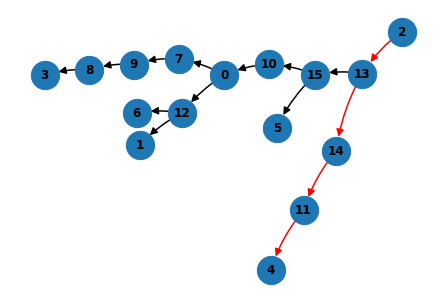

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

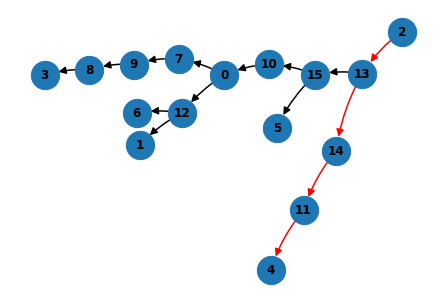

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
for tokens, masks in test_loader:
    for i in range(tokens.shape[0]):
        t = tokens[i]
        m = masks[i]
        print("Prompt:", dataset.untokenize(t[~m]))
        print("Completion:", dataset.untokenize(t[m]), end="\n\n")
    break

Prompt: 11>10,8>13,1>7,4>3,4>1,11>0,4>14,15>5,5>4,3>8,10>6,9>11,0>12,15>2,2>9|13:15
Completion: >5>4>3>8>13

Prompt: 12>6,12>5,3>7,9>12,5>4,14>1,10>15,8>2,0>10,6>0,2>13,5>8,6>11,9>3,14>9|4:14
Completion: >9>12>5>4

Prompt: 1>4,7>12,12>3,5>10,0>7,0>2,14>15,13>8,4>13,10>14,10>6,9>1,2>9,9>11,6>0|3:5
Completion: >10>6>0>7>12>3

Prompt: 1>5,8>15,6>9,14>12,4>13,5>4,9>10,12>2,14>8,10>0,12>1,6>3,2>7,9>11,1>6|7:14
Completion: >12>2>7

Prompt: 15>1,11>6,8>14,4>10,3>11,6>2,1>3,7>0,3>5,2>9,4>7,2>12,14>4,3>13,14>15|0:8
Completion: >14>4>7>0

Prompt: 14>7,7>9,9>2,1>0,8>11,3>8,2>1,3>6,1>13,12>14,3>5,11>12,2>4,3>10,4>15|0:3
Completion: >8>11>12>14>7>9>2>1>0

Prompt: 13>2,11>6,13>15,3>4,14>5,4>9,5>12,3>10,12>0,15>14,8>11,3>7,1>3,5>8,14>1|2:13
Completion: >2

Prompt: 8>5,8>0,13>2,13>10,8>14,1>13,13>11,0>3,1>7,13>6,12>8,1>4,13>12,4>15,9>1|5:9
Completion: >1>13>12>8>5

Prompt: 6>5,9>13,15>7,0>9,14>11,11>1,3>0,12>14,1>8,1>3,15>6,2>12,5>10,9>15,1>4|13:2
Completion: >12>14>11>1>3>0>9>13

Prompt: 10>9,8>5,6>1

In [5]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [6]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

In [7]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


13>2,8>4,8>13,14>0,3>8,9>5,6>14,12>3,12>10,12>9,11>6,7>12,7>11,1>7,15>1|2:15>1>7>12>3>8>13>2


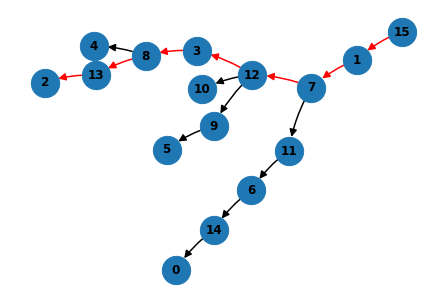

In [8]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)
print(pred)

In [9]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Experiment: Tuned Lens

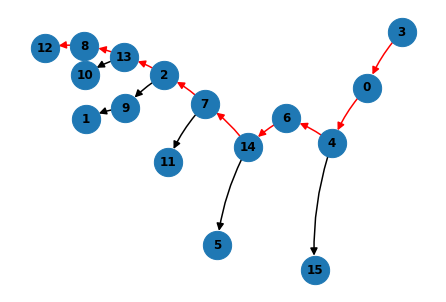

In [24]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)

In [25]:
logit_lens(pred, model, dataset)

### Experiment: Looking at Embeddings

In [16]:
embedding_matrix = model.W_E.detach().cpu().numpy()
embedding_matrix = embedding_matrix - embedding_matrix.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
embedding_matrix = embedding_matrix / row_norms

incoming_embeddings = embedding_matrix[3:19]
outgoing_embeddings = embedding_matrix[19:]
all_nodes = embedding_matrix[3:]

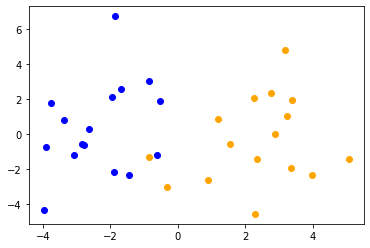

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume that 'data' is your original dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_nodes)

pca = PCA(n_components=2)  # k is the desired number of components
data_transformed = pca.fit_transform(data_scaled)

fig, ax = plt.subplots()

plt.scatter(data_transformed[:16, 0], data_transformed[:16, 1], color="blue")
plt.scatter(data_transformed[16:, 0], data_transformed[16:, 1], color="orange")

### Experiment: Probing


In [18]:
X, graphs = aggregate_activations(
    model=model,
    dataset=dataset,
    activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
    n_states=n_states,
    n_samples=1_024
)

for key in X.keys():
   tensor_list = [ x[0, [i for i in range(45) if (i-1) % 3 == 0], 0] for x in X[key] ]
   X[key] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()

In [19]:
from sklearn import preprocessing
y = {"incoming": [], "outgoing": []}

for graph in graphs:
    tokens = dataset.tokenize(graph)[:-1]
    labels = [dataset.idx2tokens[idx] for idx in tokens]
    y["outgoing"].append([labels[i-1] for i in range(45) if (i-1)%3 == 0])
    y["incoming"].append([labels[ i ] for i in range(45) if (i-1)%3 == 0])

y["incoming"] = preprocessing.LabelEncoder().fit_transform( np.array(y["incoming"]).flatten() )
y["outgoing"] = preprocessing.LabelEncoder().fit_transform( np.array(y["outgoing"]).flatten() )

In [20]:
for xkey in X.keys():    
    for ykey in y.keys():
        score = linear_probing(X[xkey], y[ykey])
        print(f"Layer {xkey.split('.')[1]} {ykey} node probe - {score:.3f}")

Layer 0 incoming node probe - 1.000
Layer 0 outgoing node probe - 0.083
Layer 1 incoming node probe - 1.000
Layer 1 outgoing node probe - 1.000
Layer 2 incoming node probe - 1.000
Layer 2 outgoing node probe - 1.000
Layer 3 incoming node probe - 1.000
Layer 3 outgoing node probe - 1.000
Layer 4 incoming node probe - 1.000
Layer 4 outgoing node probe - 1.000
Layer 5 incoming node probe - 1.000


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ c:\Users\abhay\Documents\transformers_research\planning-in-transformers\interp_utils.py:143 in   │
│ linear_probing                                                                                   │
│                                                                                                  │
│   140 │   # instantiate the model (using the default parameters)                                 │
│   141 │   out_logreg = LogisticRegression(multi_class='ovr', solver='liblinear')                 │
│   142 │   # fit the model with data                                                              │
│ ❱ 143 │   out_logreg.fit(X, y)                                                                   │
│   144 │   # predict the response for new observations                                            │
│   145 │   y_pred = out_logreg.predict(X)                                                         │
│   146 │   score = f1_score(y, y_pred, average='macro')                                           │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1358 in fit         │
│                                                                                                  │
│   1355 │   │   │   │   warnings.warn("'n_jobs' > 1 does not have any effect when"                │
│   1356 │   │   │   │   │   │   │     " 'solver' is set to 'liblinear'. Got 'n_jobs'"             │
│   1357 │   │   │   │   │   │   │     " = {}.".format(effective_n_jobs(self.n_jobs)))             │
│ ❱ 1358 │   │   │   self.coef_, self.intercept_, n_iter_ = _fit_liblinear(                        │
│   1359 │   │   │   │   X, y, self.C, self.fit_intercept, self.intercept_scaling,                 │
│   1360 │   │   │   │   self.class_weight, self.penalty, self.dual, self.verbose,                 │
│   1361 │   │   │   │   self.max_iter, self.tol, self.random_state,                               │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\sklearn\svm\_base.py:975 in _fit_liblinear            │
│                                                                                                  │
│   972 │   │   │   │   │   │   │   │   │   │    dtype=np.float64)                                 │
│   973 │                                                                                          │
│   974 │   solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)             │
│ ❱ 975 │   raw_coef_, n_iter_ = liblinear.train_wrap(                                             │
│   976 │   │   X, y_ind, sp.isspmatrix(X), solver_type, tol, bias, C,                             │
│   977 │   │   class_weight_, max_iter, rnd.randint(np.iinfo('i').max),                           │
│   978 │   │   epsilon, sample_weight)                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

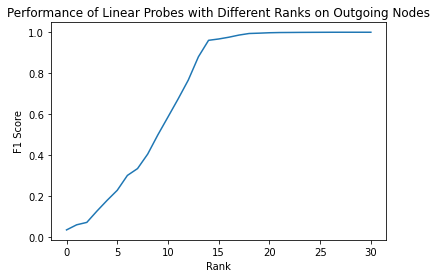

In [ ]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["outgoing"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Outgoing Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

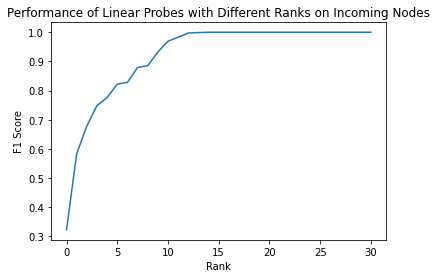

In [ ]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["incoming"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Incoming Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

### Experiment: Low Rank Approximation of Attention

In [ ]:
from functools import partial


def add_low_rank_hook(layer, k):
    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X[utils.get_act_name("v", layer, "attn")])

    # Add low-rank hook
    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[:, position, 0, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[:, position, 0, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre

    temp_hook_fn = partial(low_rank_hook, position=[i for i in range(45) if (i-1) % 3 == 0])
    model.blocks[layer].attn.hook_v.add_hook(temp_hook_fn)

In [ ]:
model.reset_hooks()
n_pca = 20

add_low_rank_hook(3, n_pca)
add_low_rank_hook(4, n_pca)
add_low_rank_hook(5, n_pca)

In [ ]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.7000%
random: 99.9000%


### Experiment: Activation Patching

In [ ]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt


def goal_distance_activation_patching(distance):
    # Generate clean and corrupted prompts
    clean_prompt, corrupted_prompt = generate_goal_distance_examples(distance)
    parse_example(clean_prompt)
    plt.show()
    parse_example(corrupted_prompt)
    plt.show()
    # Tokenize
    clean_tokens = torch.from_numpy(dataset.tokenize(clean_prompt)[0:-1]).cuda()
    corrupted_tokens = torch.from_numpy(dataset.tokenize(corrupted_prompt)[0:-1]).cuda()
    patching_result = activation_patching(model, dataset, clean_tokens, corrupted_tokens, 46 + (15 - distance + 1) )
    return patching_result, clean_tokens

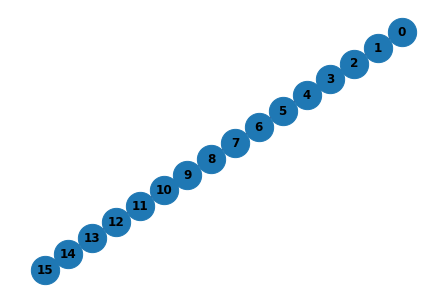

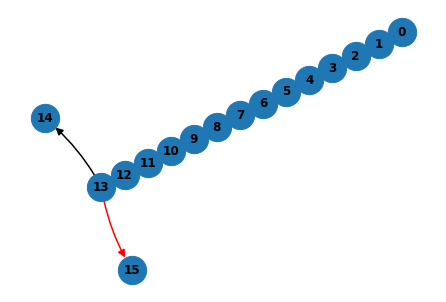

Clean logit difference: 28.632
Corrupted logit difference: -26.726
Positive Direction: >14
Negative Direction: >15


  0%|          | 0/6 [00:00<?, ?it/s]

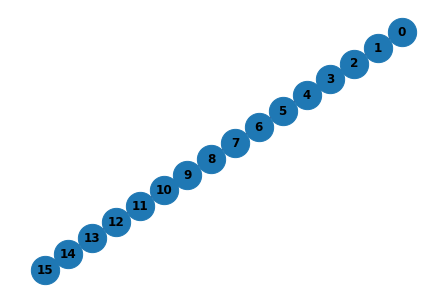

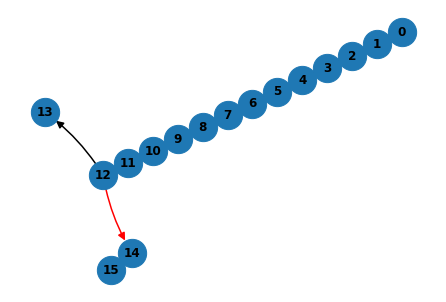

Clean logit difference: 20.599
Corrupted logit difference: -31.021
Positive Direction: >13
Negative Direction: >14


  0%|          | 0/6 [00:00<?, ?it/s]

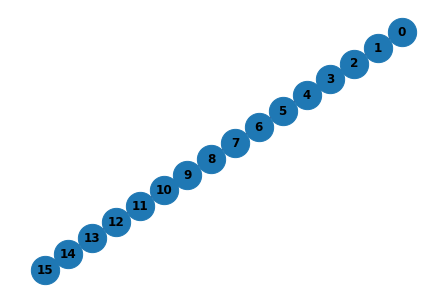

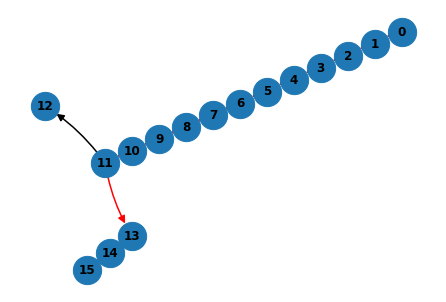

Clean logit difference: 30.959
Corrupted logit difference: -28.329
Positive Direction: >12
Negative Direction: >13


  0%|          | 0/6 [00:00<?, ?it/s]

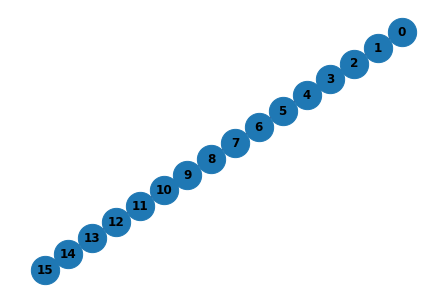

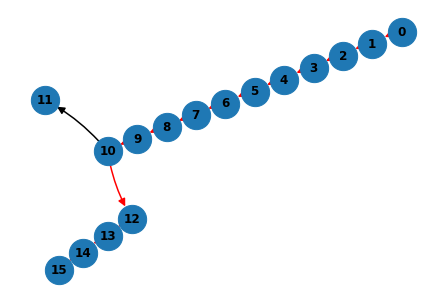

Clean logit difference: 28.172
Corrupted logit difference: -30.761
Positive Direction: >11
Negative Direction: >12


  0%|          | 0/6 [00:00<?, ?it/s]

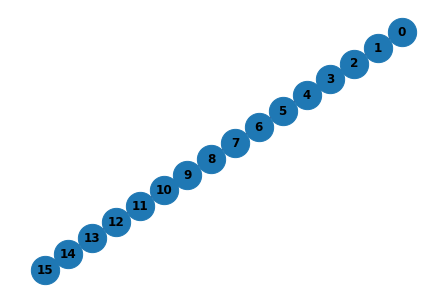

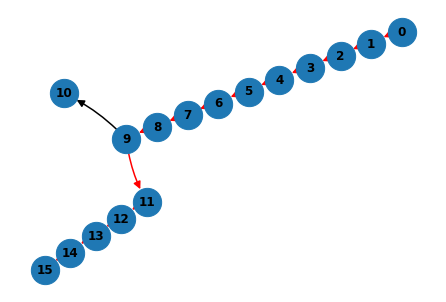

Clean logit difference: 27.548
Corrupted logit difference: -28.529
Positive Direction: >10
Negative Direction: >11


  0%|          | 0/6 [00:00<?, ?it/s]

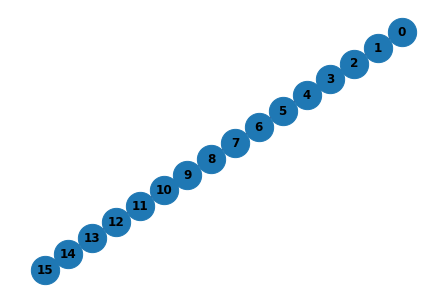

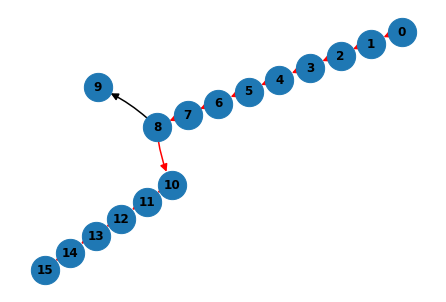

Clean logit difference: 24.128
Corrupted logit difference: -28.838
Positive Direction: >9
Negative Direction: >10


  0%|          | 0/6 [00:00<?, ?it/s]

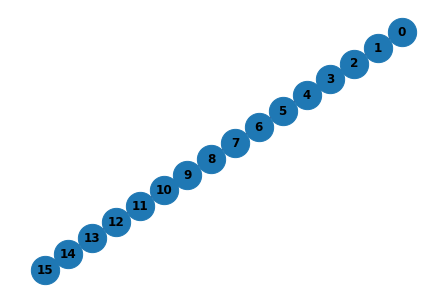

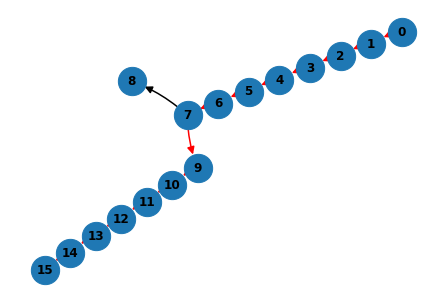

Clean logit difference: 27.738
Corrupted logit difference: -27.034
Positive Direction: >8
Negative Direction: >9


  0%|          | 0/6 [00:00<?, ?it/s]

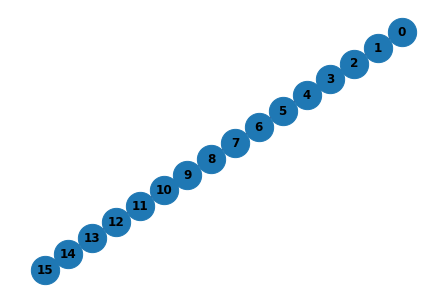

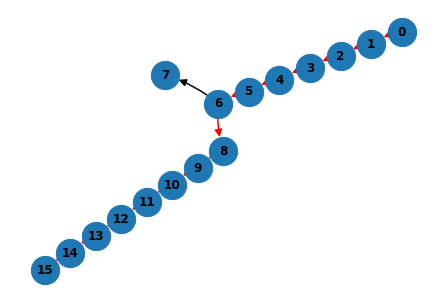

Clean logit difference: 28.092
Corrupted logit difference: -27.944
Positive Direction: >7
Negative Direction: >8


  0%|          | 0/6 [00:00<?, ?it/s]

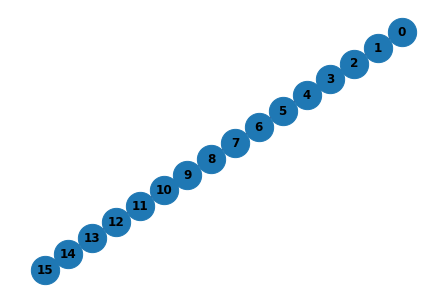

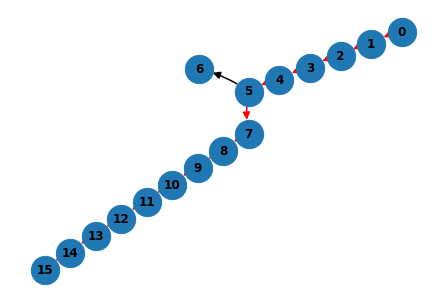

Clean logit difference: 26.328
Corrupted logit difference: -22.959
Positive Direction: >6
Negative Direction: >7


  0%|          | 0/6 [00:00<?, ?it/s]

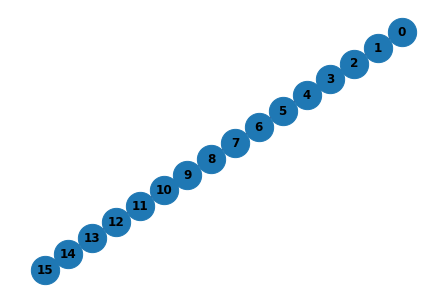

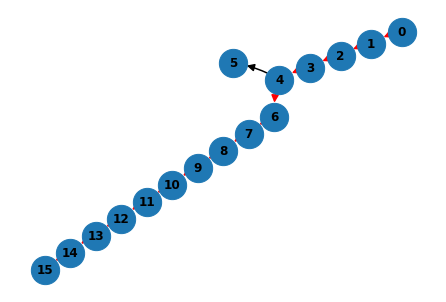

Clean logit difference: 23.962
Corrupted logit difference: -26.489
Positive Direction: >5
Negative Direction: >6


  0%|          | 0/6 [00:00<?, ?it/s]

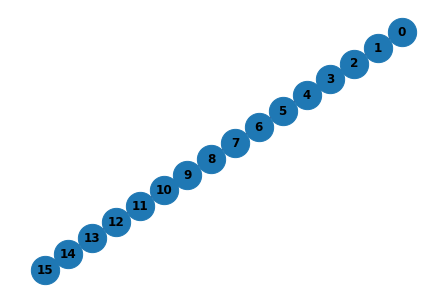

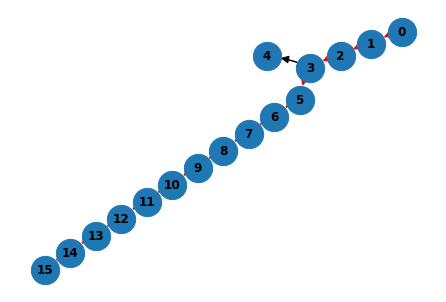

Clean logit difference: 28.749
Corrupted logit difference: -28.624
Positive Direction: >4
Negative Direction: >5


  0%|          | 0/6 [00:00<?, ?it/s]

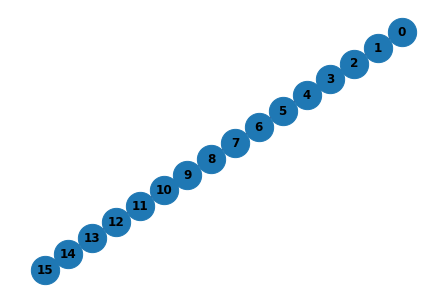

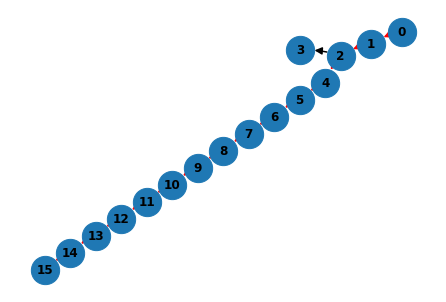

Clean logit difference: 23.565
Corrupted logit difference: -22.898
Positive Direction: >3
Negative Direction: >4


  0%|          | 0/6 [00:00<?, ?it/s]

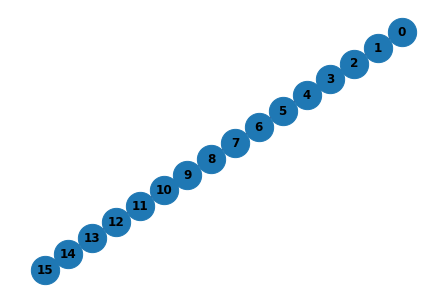

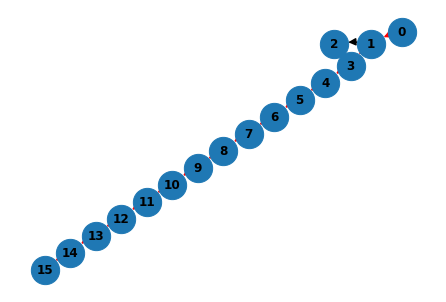

Clean logit difference: 21.542
Corrupted logit difference: -23.868
Positive Direction: >2
Negative Direction: >3


  0%|          | 0/6 [00:00<?, ?it/s]

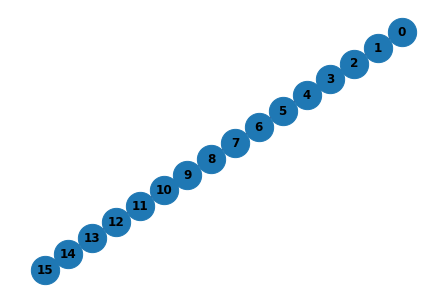

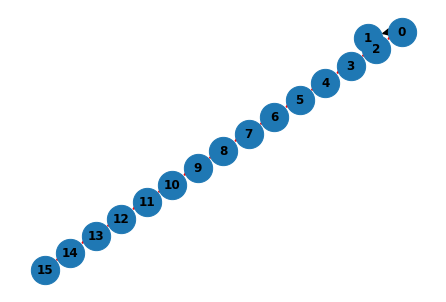

Clean logit difference: 19.914
Corrupted logit difference: -28.110
Positive Direction: >1
Negative Direction: >2


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
model.reset_hooks()
patchings = [goal_distance_activation_patching(i) for i in range(1, 15)]

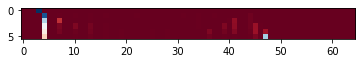

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

model.reset_hooks()
# Create a figure
fig = plt.figure()

# Function to update each frame
def update(i):
    plt.clf()
    plt.imshow(patchings[i][0].detach().cpu().numpy(), cmap='RdBu')

# Create animation

ani = animation.FuncAnimation(fig, update, frames=len(patchings), interval=200)
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, bitrate=1800)

# Save as mp4
ani.save('myAnimation.mp4', writer=writer)
HTML(ani.to_jshtml())


In [ ]:
index = 6
%matplotlib inline
plot_activations(patchings[index][0], patchings[index][1], dataset)


In [ ]:
patchings[index][0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0